In [ ]:
# install libraries:
! pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=590fefc9fd170f9f28bda9b855e91b3655550adb799d449129430f93952ab82f
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


In [ ]:
# connect to Kaggle:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.2/191.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
# Load Authentication File - https://www.kaggle.com/general/51898
# How to load authetication key - https://www.kaggle.com/docs/api
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashukla01","key":"b0652e31cce9e0350fd087c244990d74"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download lung CT dataset:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 91% 108M/119M [00:01<00:00, 128MB/s] 
100% 119M/119M [00:01<00:00, 103MB/s]


In [ ]:
! unzip -qq chest-ctscan-images.zip

In [ ]:
# import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import cv2
import matplotlib.image as mpimg
import requests, io, cv2
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [ ]:
# tensorflow:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

In [ ]:
# keras:
from keras import optimizers
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

### Creating cancerous and non cancerous dataset from original data for binary classification problem



In [ ]:
# Create a new dataset with cancerous and non cancerous images
! mkdir ct_scan

! mkdir ct_scan/train
! mkdir ct_scan/train/cancerous
! mkdir ct_scan/train/non_cancerous
! cp -r Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. ct_scan/train/cancerous/
! cp -r Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. ct_scan/train/cancerous/
! cp -r Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. ct_scan/train/cancerous/
! cp -r Data/train/normal/. ct_scan/train/non_cancerous/

! mkdir ct_scan/valid
! mkdir ct_scan/valid/cancerous
! mkdir ct_scan/valid/non_cancerous
! cp -r Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. ct_scan/valid/cancerous/
! cp -r Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. ct_scan/valid/cancerous/
! cp -r Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. ct_scan/valid/cancerous/
! cp -r Data/valid/normal/. ct_scan/valid/non_cancerous/

! mkdir ct_scan/test
! mkdir ct_scan/test/cancerous
! mkdir ct_scan/test/non_cancerous
! cp -r Data/test/adenocarcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/large.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/squamous.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/normal/. ct_scan/test/non_cancerous/

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# define data paths:
train_path = 'ct_scan/train'
val_path = 'ct_scan/valid'
test_path = 'ct_scan/test'

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(val_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 566 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


### VGG-16 Model architecture

In [ ]:
# define the base VGG model:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
# build the layers of the VGG model:
model = Sequential()
model.add(vgg_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,717,762
Trainable params: 2,050
Non-trainable params: 14,715,712
_________________________________________________________________


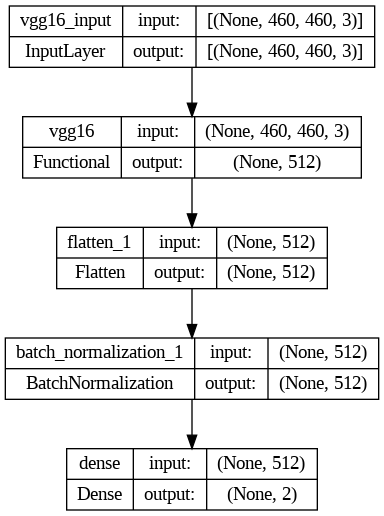

In [ ]:
# show schematic of model:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
# check model summary:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,717,762
Trainable params: 2,050
Non-trainable params: 14,715,712
_________________________________________________________________


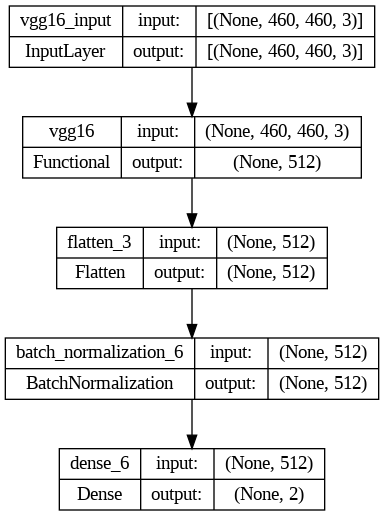

In [ ]:
# show schematic of model:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
# define the f1 score:

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define model performance metrics:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
# define checkpoints, early stopping:

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint(filepath='/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)

es = EarlyStopping(monitor='loss', patience=3)

In [ ]:
# compile the model:

optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# time and train the model:

%time
history = model.fit(train_generator,
                    steps_per_epoch = 10,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [lrd,mcp,es])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.2 µs
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5078 - acc: 0.7750  
Epoch 1: val_loss improved from inf to 0.63524, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hdf5
10/10 [==============================] - 1073s 109s/step - loss: 0.5078 - acc: 0.7750 - val_loss: 0.6352 - val_acc: 0.9365 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5455 - acc: 0.7484  
Epoch 2: val_loss improved from 0.63524 to 0.63271, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hdf5
10/10 [==============================] - 1072s 109s/step - loss: 0.5455 - acc: 0.7484 - val_loss: 0.6327 - val_acc: 0.9524 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5114 - acc: 0.7875  
Epoch 3: val_loss improved from 0.63271 to 0.62994, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hd

In [ ]:
# evaluate model performance:
model.evaluate(test_generator, verbose=1)

9/9 [==============================] - 778s 85s/step - loss: 0.6152 - acc: 0.9532


[0.6151799559593201, 0.9532374143600464]

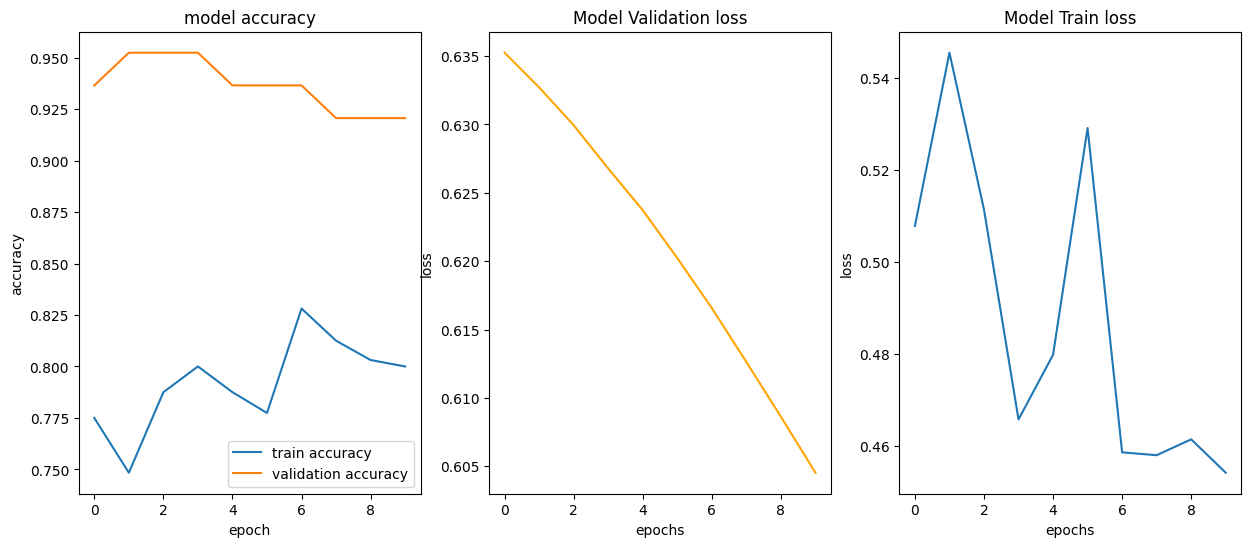

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(132)
plt.plot(history.history['val_loss'], color="orange")
plt.title('Model Validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.subplot(133)
plt.plot(history.history['loss'])
plt.title('Model Train loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
# Saving model to json
model_json = model.to_json()
with open("/content/gdrive/My Drive/SML_Project/model_vgg16.json","w") as json_file:
  json_file.write(model_json)

## Implementing LIME

In [ ]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=67ceb14fe8dbbc7ca97a7f723e47c1f86379dcae0f1a31c9629b8e7005db99c0
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [ ]:
IMG_SIZE = (460, 460)
def transform_image(img):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

In [ ]:
test_generator.class_indices

{'cancerous': 0, 'non_cancerous': 1}

In [ ]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    if model_prediction[0][0] > model_prediction[0][1] :
      print(f"The predicted class is : cancerous with probability - {model_prediction[0][0]}")
    else :
      print(f"The predicted class is : non cancerous with probability - {model_prediction[0][1]}")
    # return decode_predictions(model_prediction, top=1)[0][0][1]

In [ ]:
from skimage.segmentation import mark_boundaries

def masked_explaind_images(exp) :
  temp_1, mask_1 = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  temp_2, mask_2 = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
  ax1.imshow(mark_boundaries(temp_1, mask_1))
  ax2.imshow(mark_boundaries(temp_2, mask_2))
  ax1.axis('off')
  ax2.axis('off')

In [ ]:
explainer = lime_image.LimeImageExplainer()
def lime(path):
  img = image.load_img(path, target_size=IMG_SIZE)
  normalized_img = transform_image(img)

  plt.imshow(normalized_img[0])
  # pred_orig = get_model_predictions(normalized_img) 

  exp = explainer.explain_instance(normalized_img[0], 
                                  model.predict)
  masked_explaind_images(exp)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 26s 26s/step


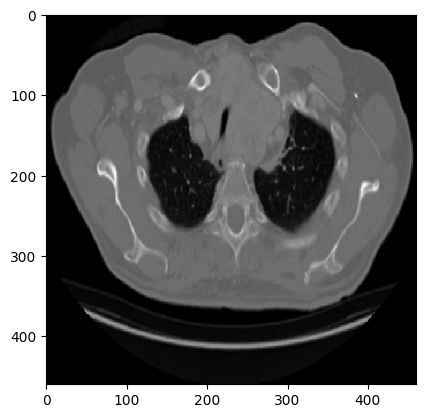

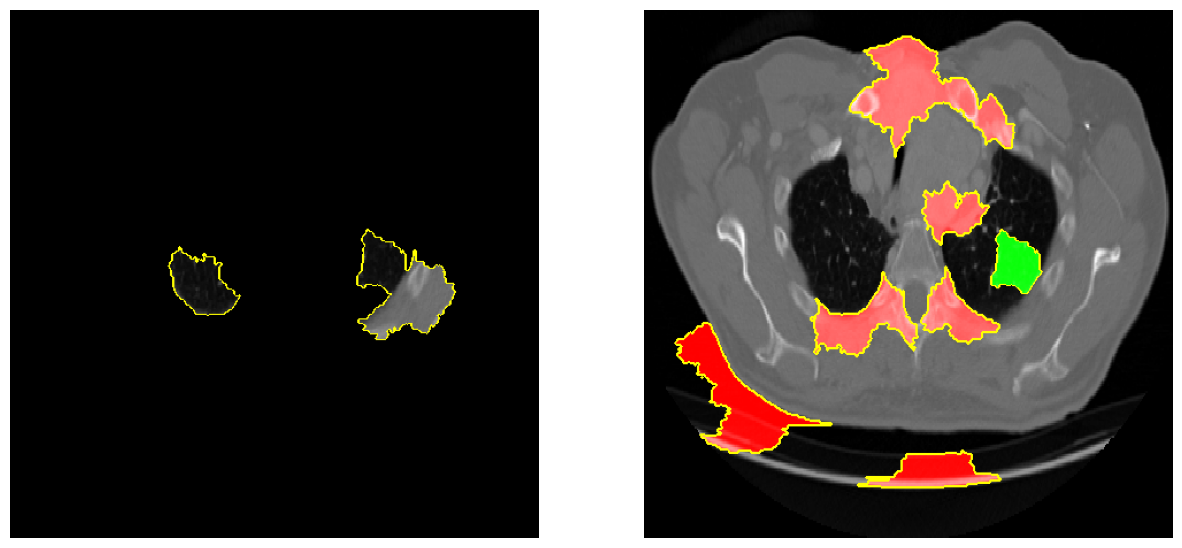

In [ ]:
image_paths = ["/content/ct_scan/test/cancerous/000108.png", "/content/ct_scan/test/non_cancerous/21.png"]

lime(image_paths[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 29s 29s/step


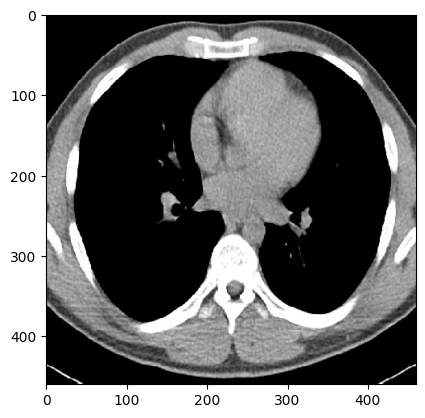

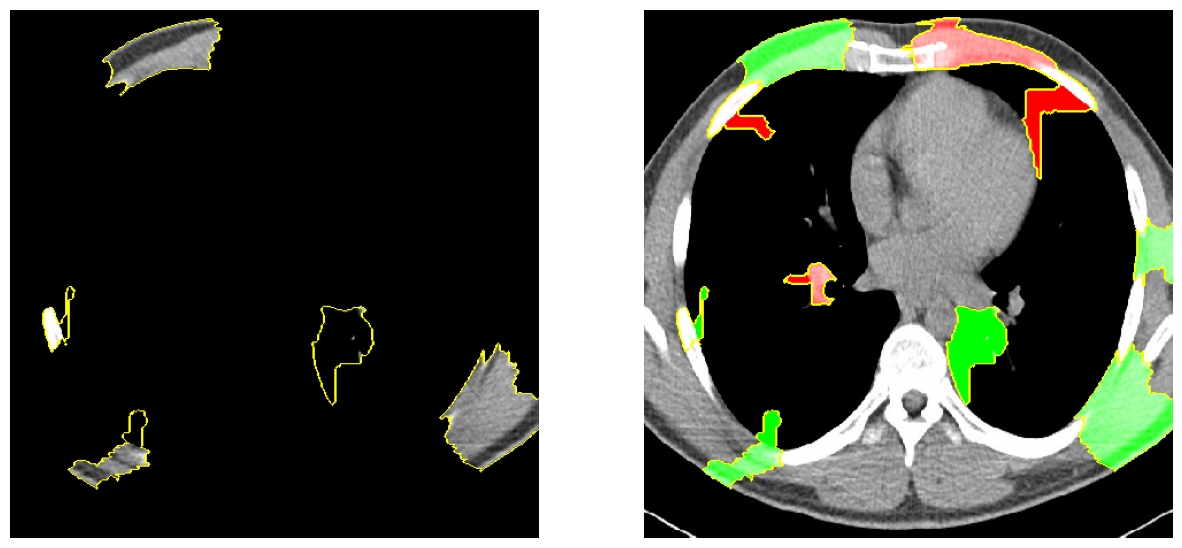

In [ ]:
lime(image_paths[1])